# Cosine Angle Computation for MTI

In [4]:
# LOCATION
from pyfrac.imaging.kirchhoff import Kirchhoff

from pyfrac.visualisation.plotting_support import explode_volume

In [155]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3D Model - Homo

In [6]:
# Velocity Model
nx, ny, nz = 45, 50, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 132)
[[  4 164 148 132 116 100  84  68  52  36  20   4 164 148]
 [  4   4  20  36  52  68  84 100 116 132 148 164 164 180]
 [  4   4   4   4   4   4   4   4   4   4   4   4   4   4]]


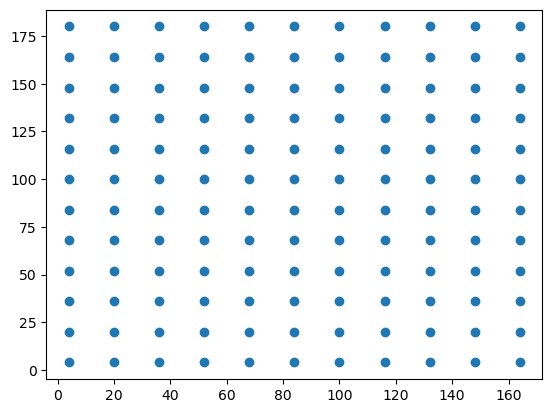

In [13]:
# RECEIVERS
dr_xyz = 4*dx

grid_rx_locs = np.arange(dx, (dx*nx)-dx, dr_xyz)
grid_ry_locs = np.arange(dy, (dy*ny)-dy, dr_xyz)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)
print(recs[:,::10])

# COLLECT NECESSARY INFORMATION FOR SOURCE LOCATIONS

- Traveltime Tables
- Take-off Angles
- Receiver Angles

## COMPUTE TRAVELTIME - NR,NX,NY,NZ

In [ ]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs, 
                                   srcs=recs[:,:1], 
                                   vel=vel, 
                                   mode='eikonal')[1]

In [ ]:
TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

In [ ]:
np.mean(TTT_full)

In [ ]:
explode_volume(TTT_full[nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='rainbow',
                   figsize=(8, 8), clipval=None, p=98,
                   tlim=None, xlim=None, ylim=None,
                   tcrop=None, xcrop=None, ycrop=None,
                   labels=('[x]', '[y]', '[z]'),
                   tlabel='x', xlabel='y', ylabel='z',
                   ratio=None, linespec=None, interp=None, title='',
                   filename=None, save_opts=None)

# STRAIGHT RAY ASSUMPTION: SOURCE ANGLES = RECEIVER ANGLES



In [55]:
nc = 3  # number of axis components, for 3D then 3 < assumes geophones

gamma_sourceangles = np.zeros([nc, nr, nx, ny, nz])
dist_table = np.zeros([nr, nx, ny, nz])

for irec in range(nr):
    rx,ry,rz = recs[0, irec], recs[1, irec], recs[2, irec]
    
    s_locs_x, s_locs_y, s_locs_z = np.meshgrid(x, y, z, indexing='ij')

    # Compute 'distances'
    delta_x = s_locs_x - rx
    delta_y = s_locs_y - ry
    delta_z = s_locs_z - rz
    total_distance = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)
    dist_table[irec] = total_distance
    
    # cosine x
    gamma_sourceangles[0,irec] = delta_x / total_distance
    # cosine y
    gamma_sourceangles[1,irec] = delta_y / total_distance
    # cosine z
    gamma_sourceangles[2,irec] = delta_z / total_distance
    
    # At rec loc total distance is zero < CANT DIVIDE BY ZERO!
    rl = np.argwhere(total_distance==0)[0]
    gamma_sourceangles[:,irec,rl[0],rl[1],rl[2]] = 0

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='z samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

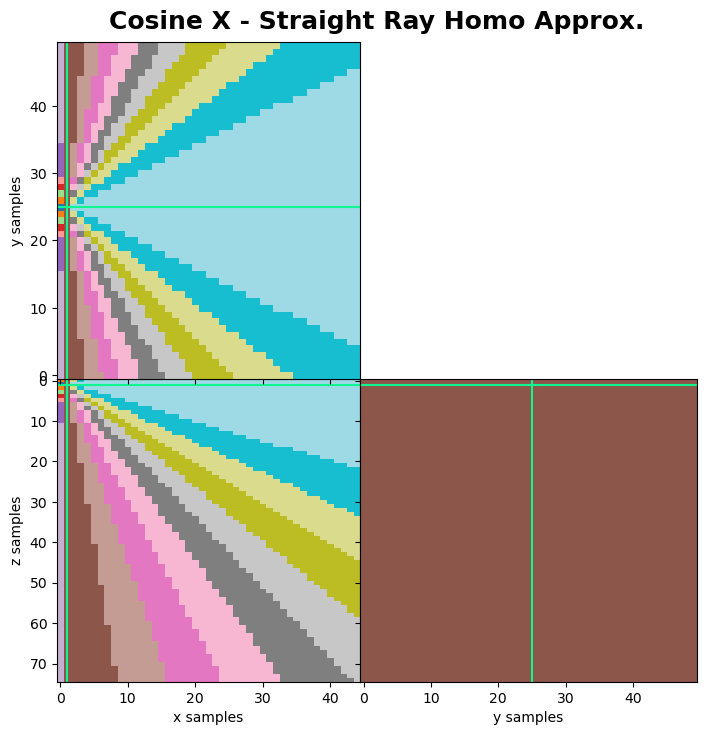

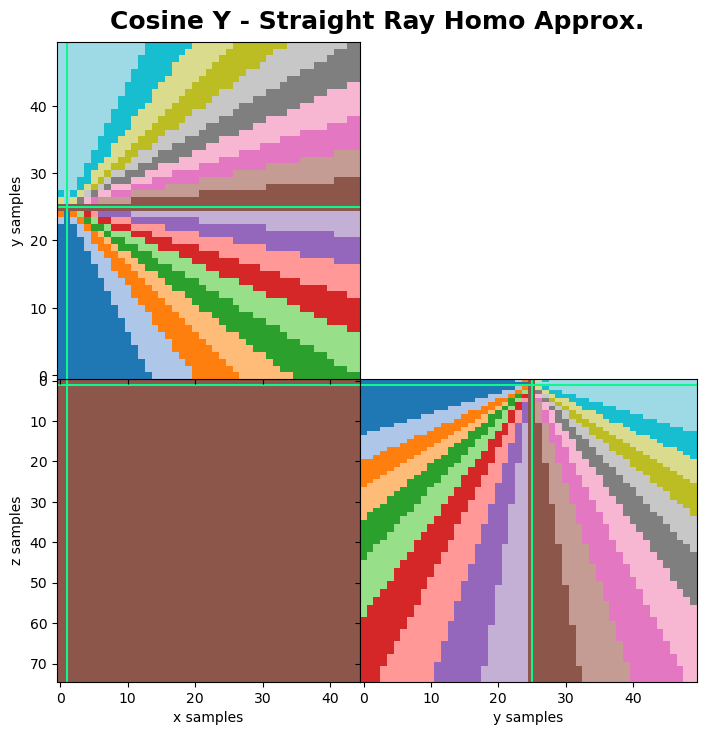

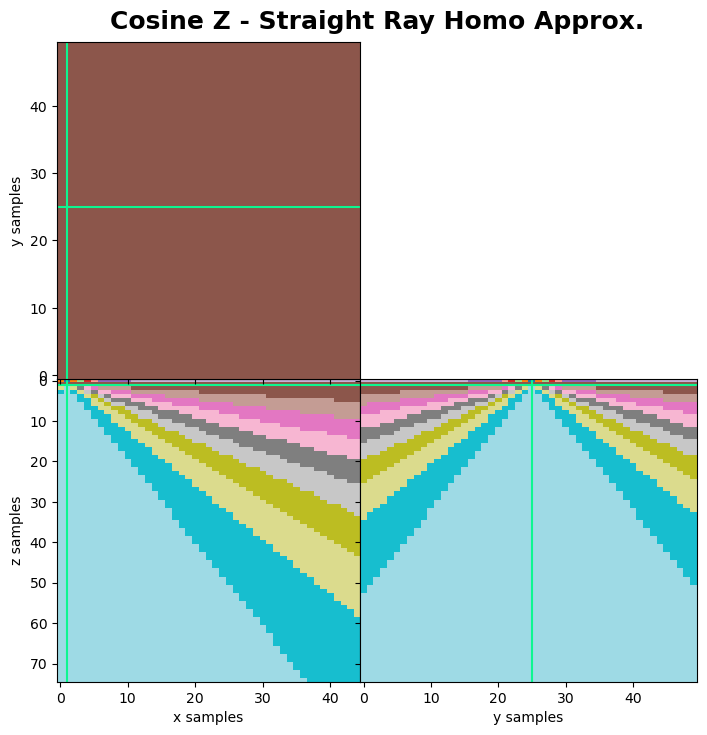

In [47]:
explode_volume(gamma_sourceangles[0,nr//2].transpose(2,0,1), 
               t=int(recs[2,nr//2]/dx), 
               x=int(recs[0,nr//2]/dy), 
               y=int(recs[1,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='Cosine X - Straight Ray Homo Approx.',
               )
explode_volume(gamma_sourceangles[1,nr//2].transpose(2,0,1), 
               t=int(recs[2,nr//2]/dx), 
               x=int(recs[0,nr//2]/dy), 
               y=int(recs[1,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='Cosine Y - Straight Ray Homo Approx.',
               )
explode_volume(gamma_sourceangles[2,nr//2].transpose(2,0,1), 
               t=int(recs[2,nr//2]/dx), 
               x=int(recs[0,nr//2]/dy), 
               y=int(recs[1,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='Cosine Z - Straight Ray Homo Approx.',
               )

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

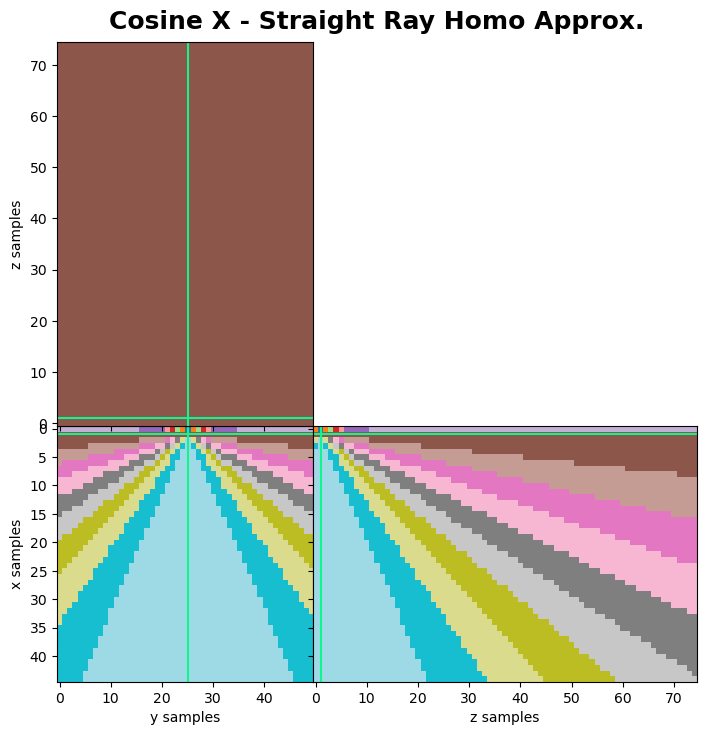

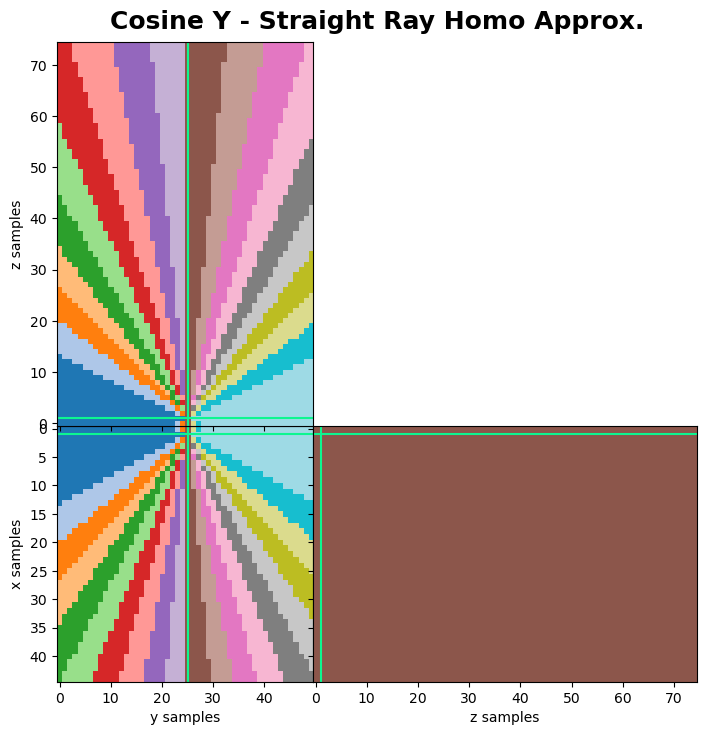

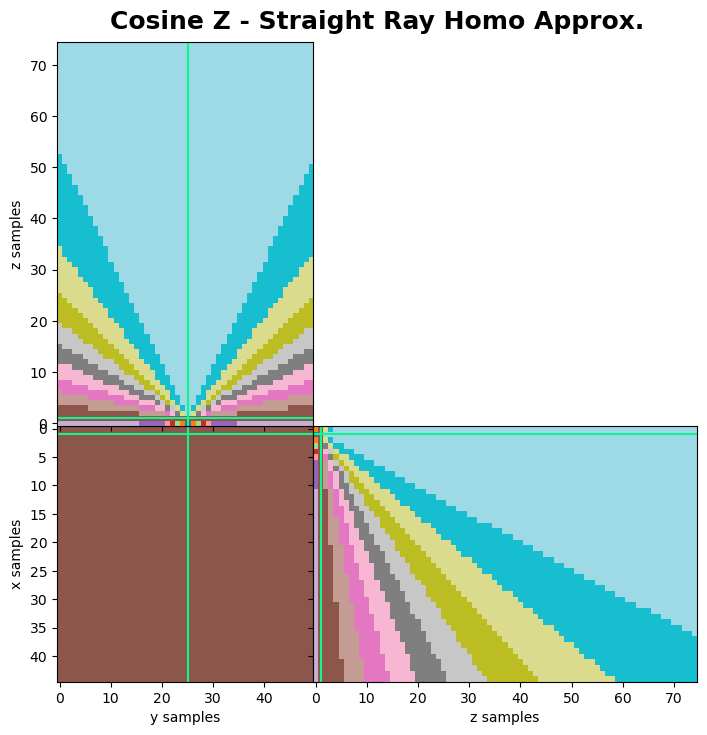

In [44]:
explode_volume(gamma_sourceangles[0,nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               figsize=(8, 8),
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               title='Cosine X - Straight Ray Homo Approx.',
               )

explode_volume(gamma_sourceangles[1,nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               figsize=(8, 8),
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               title='Cosine Y - Straight Ray Homo Approx.',)

explode_volume(gamma_sourceangles[2,nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='tab20',               
               clipval=[-1,1],
               figsize=(8, 8),
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               title='Cosine Z - Straight Ray Homo Approx.',
               )

# MTI - ACTUAL IMPLEMENTATION

## Make Greens Matrix [6 x nr]

Rows correspond to the six elements of which the different MT components are multiplied by FOR A SINGLE RECEIVER

In [64]:
# Pre-make dictionary of the MT components values 
MT_comp_dict = [{'elementID':0, 'laymans':'xx', 'pq':[0,0], 'ODscaler':1, 'MCweighting':1},
                {'elementID':1, 'laymans':'yy', 'pq':[1,1], 'ODscaler':1, 'MCweighting':1},
                {'elementID':2, 'laymans':'zz', 'pq':[2,2], 'ODscaler':1, 'MCweighting':1},
                {'elementID':3, 'laymans':'xy', 'pq':[0,1], 'ODscaler':2, 'MCweighting':1},
                {'elementID':4, 'laymans':'xz', 'pq':[0,2], 'ODscaler':2, 'MCweighting':1},
                {'elementID':5, 'laymans':'yz', 'pq':[1,2], 'ODscaler':2, 'MCweighting':1},
               ]

'''
elementID < indicing style
laymans < MT component in seismic terminology
pq < indices of the two component parameters
ODscaler < off-diagonal scaler, allows multiplication of OD elements by 2 so can work on 6 MT components as opposed to 9
MCweighting < for weighting MC component importance [TO-DO]
'''

'\nelementID < indicing style\nlaymans < MT component in seismic terminology\npq < indices of the two component parameters\nODscaler < off-diagonal scaler, allows multiplication of OD elements by 2 so can work on 6 MT components as opposed to 9\nMCweighting < for weighting MC component importance [TO-DO]\n'

VARIABLE TO USE
- gamma_sourceangles 
- dist_table 

In [65]:
# Components used by all 
omega_p = 25  # Assume central frequency of 25Hz
alpha = np.mean(vel) 

all_scaler = omega_p/(4*np.pi * alpha**3)

In [66]:
# SLICE ON SOURCE LOC
sloc_ind = [20, 25, 50]  # x,y,z indices of source location
dist_sloc = dist_table[:, sloc_ind[0],sloc_ind[1],sloc_ind[2]]
gamma_sloc = gamma_sourceangles[:, :, sloc_ind[0],sloc_ind[1],sloc_ind[2]]

In [69]:
G_z = np.zeros([6,nr]) # Z-component
zcomp_gamma_ind = 2  # Gamma index related to 
for irec in range(nr):
    for cmp_dict in MT_comp_dict:
        el_indic = cmp_dict['elementID']
        p_gamma_ind, q_gamma_ind = cmp_dict['pq']
        
        gamma_elements = gamma_sloc[zcomp_gamma_ind,irec] * gamma_sloc[p_gamma_ind,irec] * gamma_sloc[q_gamma_ind,irec] 
        
        G_z[el_indic,irec] = all_scaler * gamma_elements * dist_sloc[irec]**-1 
        # print(el_indic, el_p, el_q)

In [83]:
G_z.shape

(6, 132)

## FORWARD PASS

In [141]:
Mxx = 1
Myy = 1
Mzz = 1
Mxy = 0
Mxz = 0
Myz = 0
MTscale = 1/np.sqrt(3)

MT = MTscale * np.array([Mxx, Myy, Mzz, Mxy, Mxz, Myz])
u_zp = np.matmul(G_z.T, MT)

In [265]:
MT_list = [np.array([1,1,1,0,0,0]),
           -1 * np.array([1,1,1,0,0,0]),
           -1 * np.array([0,0,0,1,0,0]),
           np.array([1,-1,0,0,0,0]),
           np.array([-1,0,1,0,0,0]),
           np.array([0,-1,1,0,0,0]),
           np.array([1,-2,1,0,0,0]),
           np.array([-2,1,1,0,0,0]),
          ]

[1 1 1 0 0 0]
[-1 -1 -1  0  0  0]
[ 0  0  0 -1  0  0]
[ 1 -1  0  0  0  0]
[-1  0  1  0  0  0]
[ 0 -1  1  0  0  0]
[ 1 -2  1  0  0  0]
[-2  1  1  0  0  0]


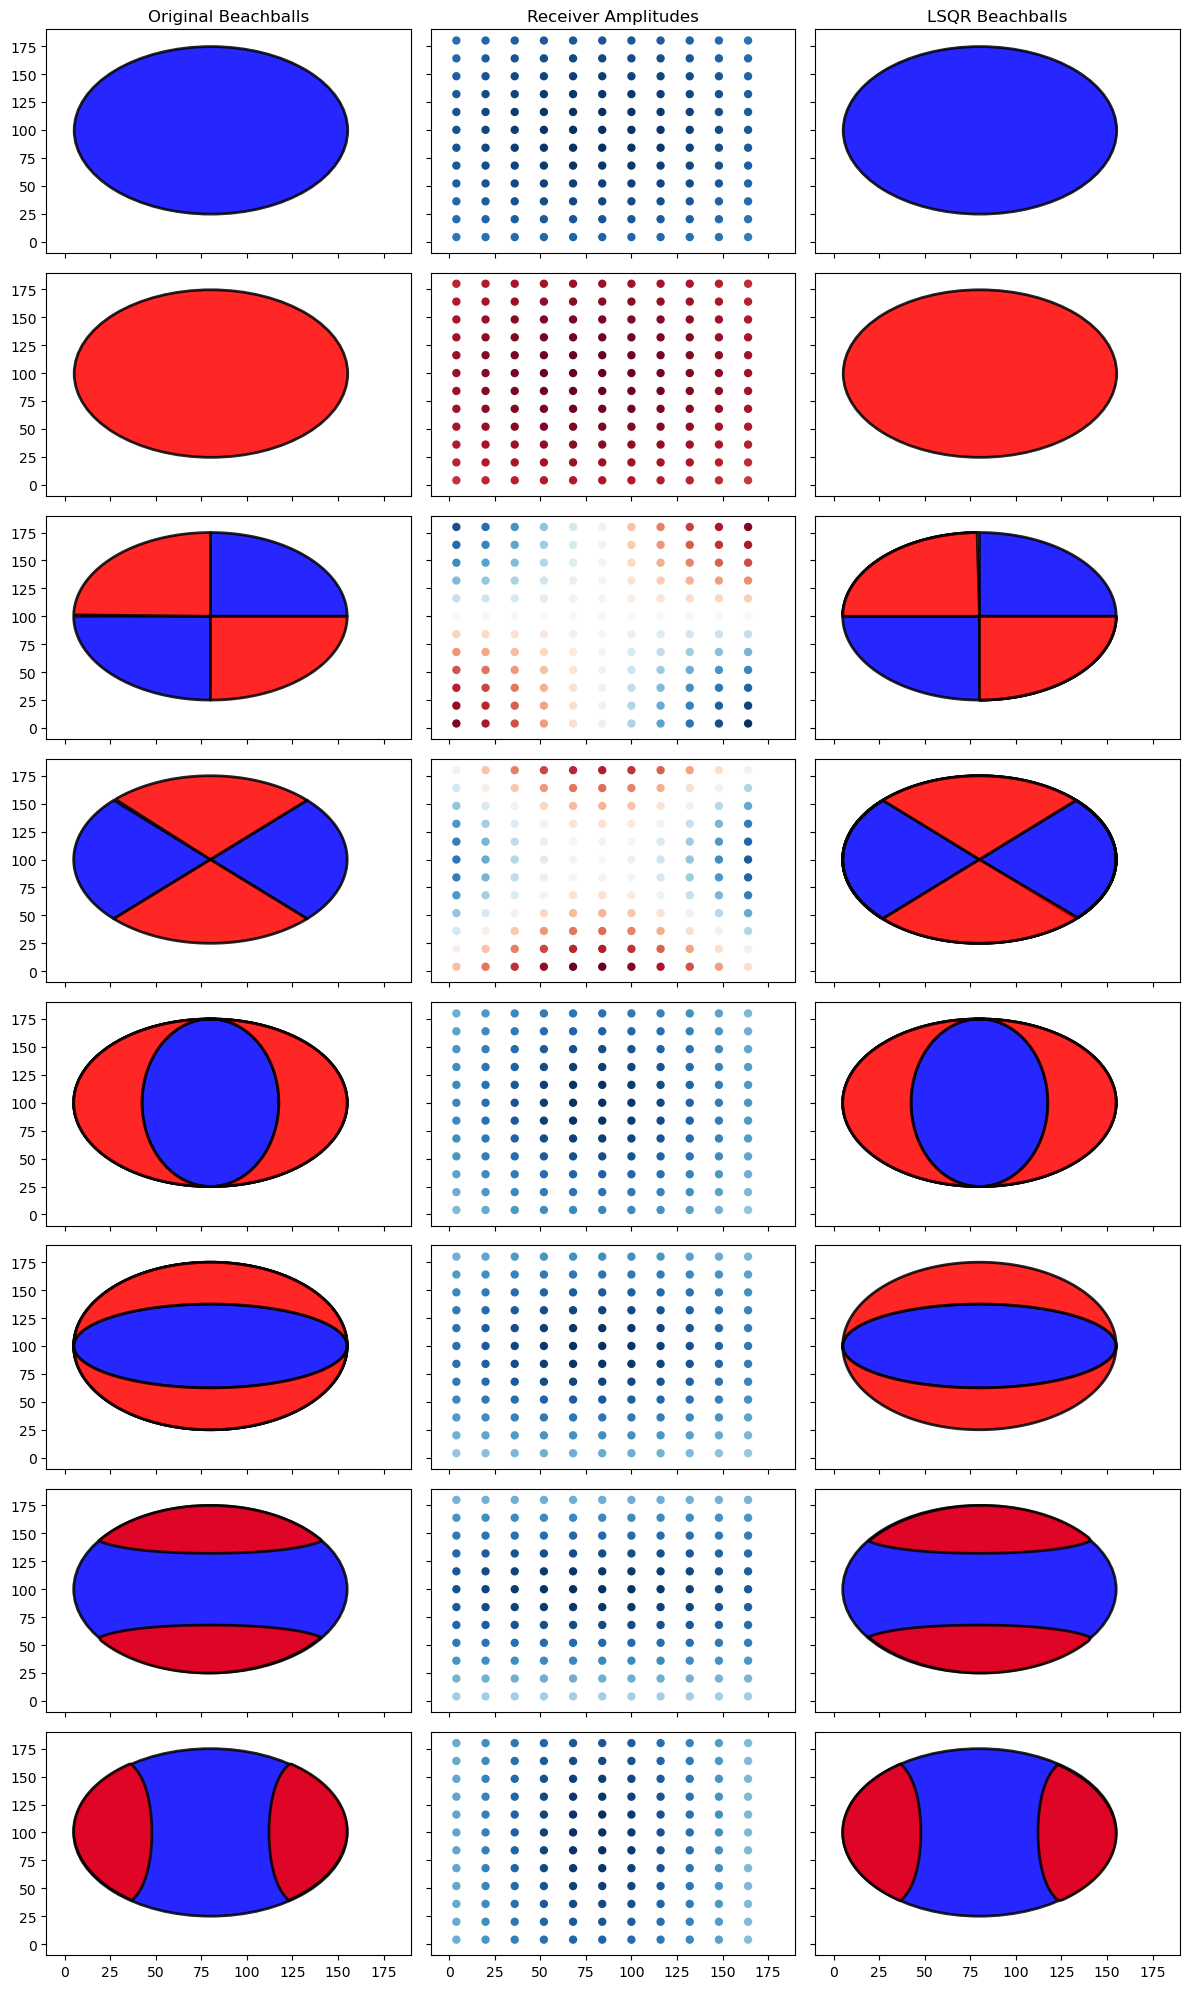

In [271]:
fig,axs = plt.subplots(len(MT_list),3, figsize=[12,20], sharex=True, sharey=True)
for ax in axs.ravel(): ax.set_xlim(-10,190); ax.set_ylim(-10,190)
for i,MT in enumerate(MT_list):

    # For beachball swap x and z locs
    MT_BB = MT.copy()
    MT_BB[0], MT_BB[2] = MT_BB[2], MT_BB[0]
    MT_BB[5] = MT_BB[3]
    MT_BB[3] = MT_BB[4]
    b = beach(MT_BB, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')
    b.set_zorder(10)
    axs[i,0].add_collection(b) 
    
    # FORWARD
    u_zp = np.matmul(G_z.T, MT)
    axs[i,1].scatter(recs[0], recs[1], c=u_zp.squeeze(), s=25, marker='o', cmap='RdBu', vmin=-np.max(abs(u_zp)), vmax=np.max(abs(u_zp)))
    print(MT)
    # BACKWARD LEAST SQUARES
    MT_ls, res, rnk, s  = lstsq(G_z.T, u_zp)

    # For beachball swap x and z locs
    MT_BB_ls = MT_ls.copy()
    MT_BB_ls[0], MT_BB_ls[2] = MT_BB_ls[2], MT_BB_ls[0]
    MT_BB_ls[5] = MT_BB_ls[3]
    MT_BB_ls[3] = MT_BB_ls[4]
    b_ls = beach(MT_BB_ls, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')
    b_ls.set_zorder(10)
    axs[i,2].add_collection(b_ls) 

axs[0,0].set_title('Original Beachballs')
axs[0,1].set_title('Receiver Amplitudes')
axs[0,2].set_title('LSQR Beachballs')

plt.tight_layout()
plt.savefig('MTI_InverseCrime.png')

In [142]:
u_zp.max()

5.8577738767320255e-12

Text(0.5, 1.0, 'Forward MT Amplitudes \n MT: [0.57735027 0.57735027 0.57735027 0.         0.         0.        ]')

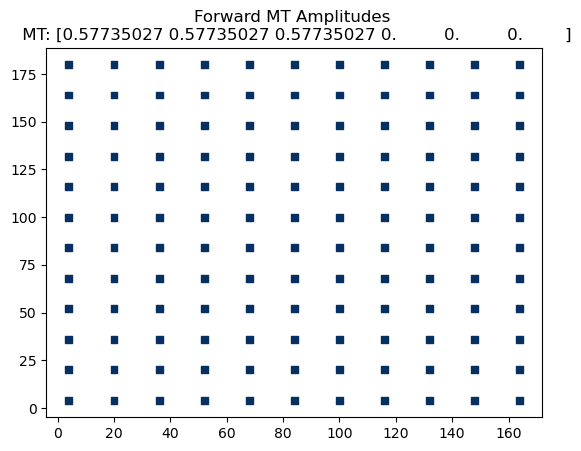

In [144]:
plt.scatter(recs[0], recs[1], c=u_zp.squeeze(), s=25, marker='s', cmap='RdBu', vmin=-1e-12, vmax=1e-12)
plt.title('Forward MT Amplitudes \n MT: %s'%str(MT))

# BACKWARD PASS

In [173]:
from scipy.linalg import lstsq

In [186]:
MT_ls, res, rnk, s  = lstsq(G_z.T, u_zp)

In [188]:
MT_ls

array([ 5.77350269e-01,  5.77350269e-01,  5.77350269e-01,  3.19709503e-16,
       -2.49389490e-17,  7.90353297e-17])